In [158]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distanse import hamming
from distfit import distfit
%matplotlib inline

In [159]:
PD_COUNT = 250

MIN_PD = 300.0
MAX_PD = 1200.0
MIN_DIVIATION = -0.05
MAX_DIVIATION = +0.05

SAME_DELAYS = False
# SAME_DELAYS = True

In [160]:
def select_pairs_of_indexes(count: int) -> np.array:
    pairs = list()
    for i in range(0, count):
        for j in range(0, count):
            if i != j:
                pairs.append((i, j))

    return np.array(pairs)


def get_pd_with_diviation(pd: float) -> float:
    return pd * (1 + np.random.uniform(MIN_DIVIATION, MAX_DIVIATION))


def calc_bit_vector(pd: np.array, pairs: list) -> np.array:
    bit_vector = np.zeros(len(pairs), dtype=np.int32)

    for i, pair in enumerate(pairs):
        x = get_pd_with_diviation(pd[pair[0]])
        y = get_pd_with_diviation(pd[pair[1]])

        res = 1 if x < y else 0
        bit_vector[i] = res

    return np.array(bit_vector, dtype=np.int32)


def generate_propagation_delays(same_delays: bool, pd_count: int) -> np.array:
    if SAME_DELAYS:
        return np.full(pd_count, MIN_PD, dtype=np.float32)
    else:
        return np.random.uniform(size=pd_count, low=MIN_PD, high=MAX_PD)


def calc_uniformity(bit_vector: np.array) -> float:
    unique, counts = np.unique(bit_vector, return_counts=True)
    uniformity = counts[1] / bit_vector.size
    return uniformity


def calc_uniqueness(bit_vector: np.array) -> float:
    
    return 42

# def ne_bit_vectors(a: list, b: list) -> bool:
    # return any(list(map(lambda x: x[0] != x[1], zip(a, b))))

[distfit] >INFO> fit
[distfit] >INFO> transform
[distfit] >INFO> [norm] [0.00 sec] [RSS: nan] [loc=0.501 scale=0.000]
[distfit] >INFO> [norm] [0.00 sec] [RSS: nan] [loc=0.501 scale=0.000]
[distfit] >INFO> Compute confidence intervals [parametric]
[distfit] >INFO> Create pdf plot for the parametric method.
[distfit] >INFO> Estimated distribution: Norm(loc:0.500610, scale:0.000000)


NameError: name 'hamming' is not defined

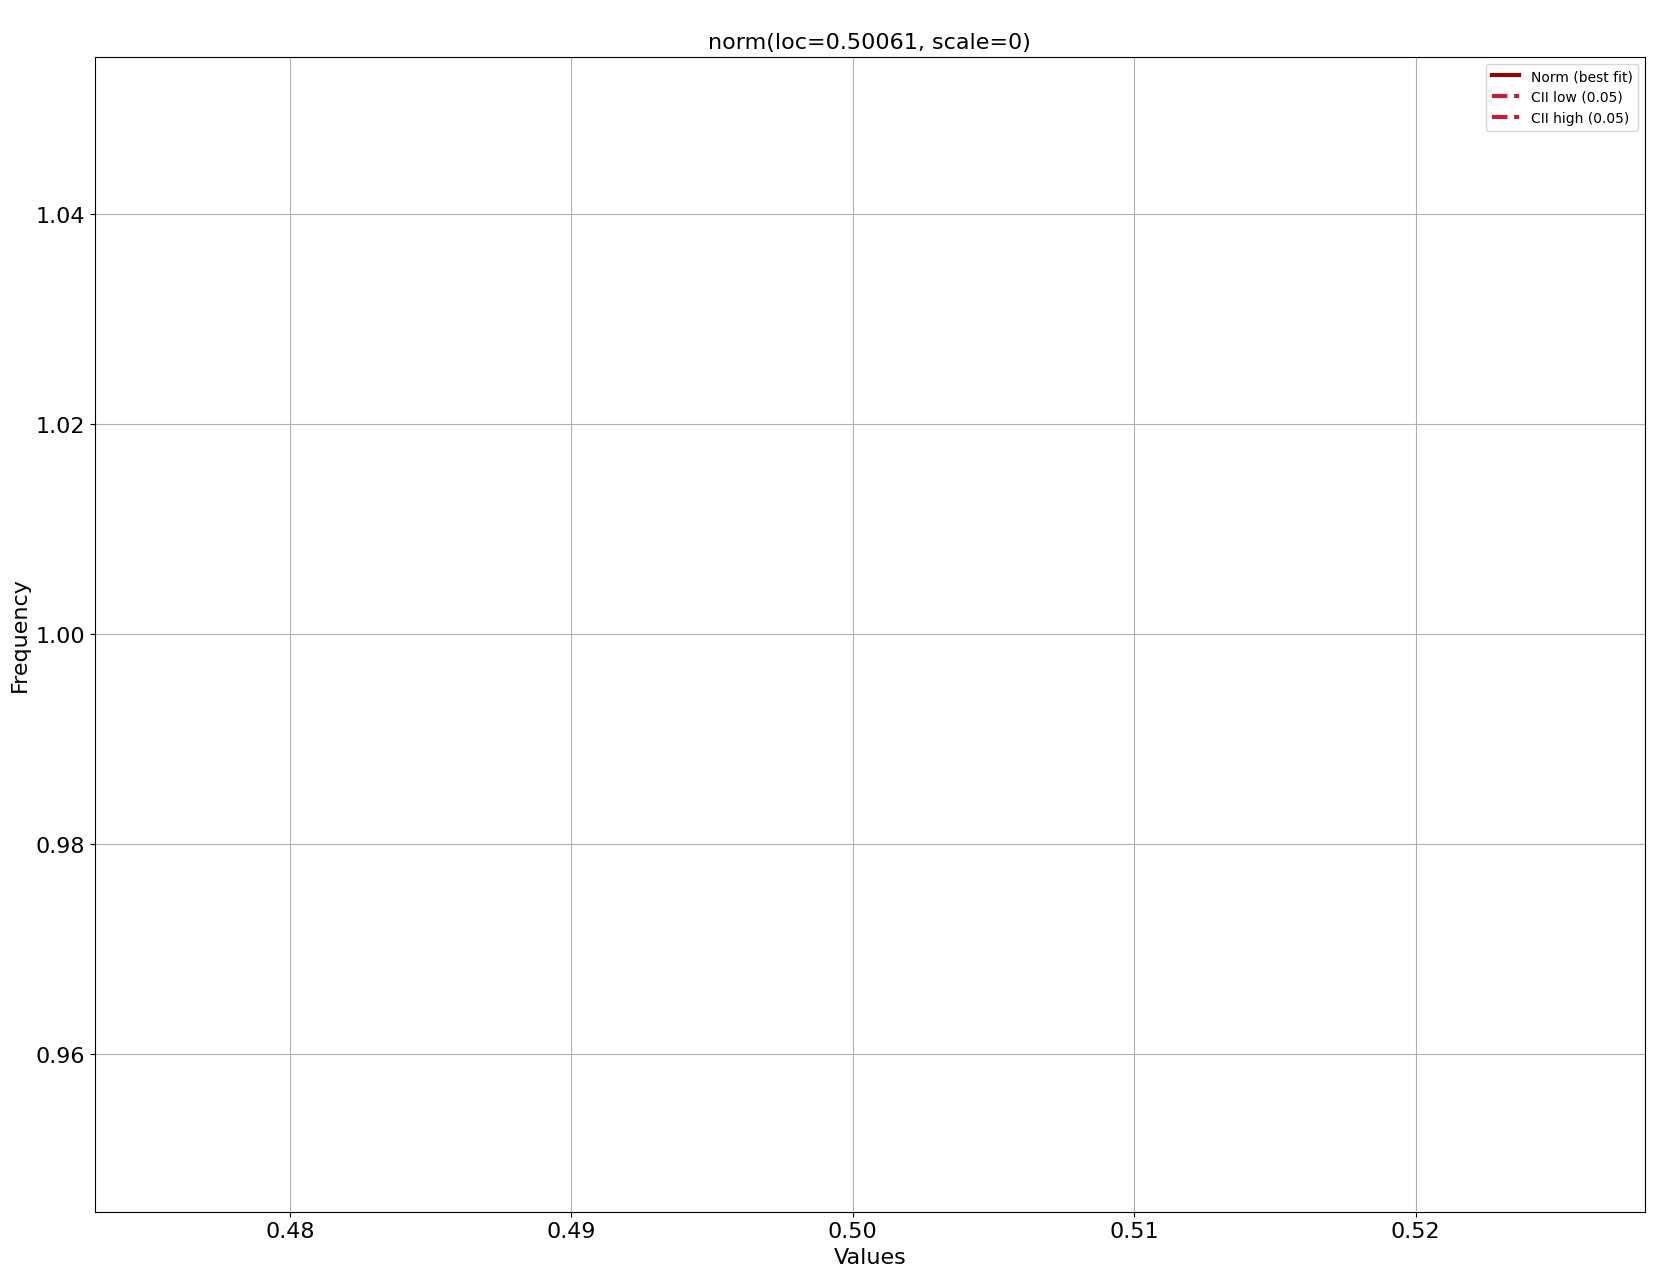

In [170]:
def plot_results(res: np.array):
    dfit = distfit(distr="norm")
    dfit.fit_transform(res)
    dfit.plot()


def analyze_unif(responses: list):
    total = np.zeros(len(responses), dtype=np.float32)

    for i in range(len(responses)):
        total[i] = calc_uniformity(responses[i])

    plot_results(total)


def analyze_uniquness(responses: list):
    total = np.zeros(len(responses), dtype=np.float32)
    a = [1, 2, 3]
    b = [1, 2, 4]
    v = hamming(a, b)
    print(v)



pd = generate_propagation_delays(SAME_DELAYS, PD_COUNT)
pairs = select_pairs_of_indexes(pd.size)
AMOUNT_OF_ITERATIONS = 1
responses = []
for _ in range(AMOUNT_OF_ITERATIONS):
    bit_vector = calc_bit_vector(pd, pairs)
    responses.append(bit_vector)

analyze_unif(responses)
analyze_uniquness(responses)
   
# ax = plt.gca()
# dfit.plot(ax=ax)